#### media: 사용자의 local에 저장되어 있는 이미지 파일
#### metadata: 사용자의 설정에 따라 CALORIE와 NATRIUM 정보 출력
* UNSELECTED: 표시할 정보 없음
* CALORIE: 칼로리 정보 표시
* NATRIUM: 나트륨 정보 표시
* ALL: 식품 코드, 1회 제공량, 칼로리, 나트륨, 탄수화물, 단백질, 지방, 당류, 콜레스테롤 정보 표시
#### 지원 포맷: jpg / png / bmp / tiff
#### 이미지 크기 제한
* 최소: 1080 x 720 ( width가 height보다 긴 이미지의 경우) / 720 x 1080 ( height가 width보다 긴 이미지의 경우)
* 최대: 2560 x 1440 ( width가 height보다 긴 이미지의 경우) / 1440 x 2560 ( height가 width보다 긴 이미지의 경우)

In [1]:
from PIL import Image
# pillow 사용 이미지 사이즈 조절
def img_size_pillow(img_path):
    image = Image.open(img_path)
    print("Before :",image.size)  # 이미지의 크기 출력 (너비, 높이)
    if image.size[0] > image.size[1]:
        print("resizeing")
        resized_image = image.resize((1080, 720))
        resized_image.save(img_path)
    elif image.size[1] > image.size[0]:
        print("resizeing2")
        resized_image = image.resize((720, 1080))
        resized_image.save(img_path)
    else:
        print("resizeing3")
        resized_image = image.resize((1080, 1080))
        resized_image.save(img_path)
    print("After :",image.size)

In [2]:
# 이미지 확인용 폰트 설정
from PIL import ImageFont, ImageDraw
import numpy as np

def myPutText(src, text, pos, font_size, font_color) :
    img_pil = Image.fromarray(src)
    draw = ImageDraw.Draw(img_pil)
    font = ImageFont.truetype('fonts/gulim.ttc', font_size)
    draw.text(pos, text, font=font, fill= font_color)
    return np.array(img_pil)

In [3]:
# 추가 항목 : 음료 관련 학습

Image resized and saved.
<_io.BufferedReader name='/data/BP/BP_Api_File/test_img/test.jpg'>
-------------- <class '_io.BufferedReader'>
Code: 200
{'confidence': 0.8366454, 'food_name': '짬뽕', 'food_code': 'D018181', 'food_cal': 464.46, 'food_nat': 1446.06, 'food_serving_size': 800.0, 'food_carbs': 66.06, 'food_protein': 22.3, 'food_fat': 12.34, 'food_sugar': 12.52, 'food_cholesterol': 84.18}


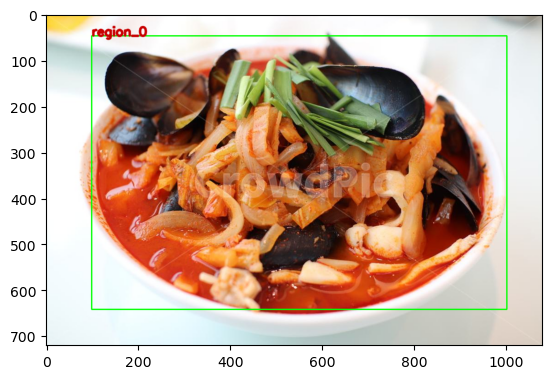

In [4]:
import requests
import json
from datetime import datetime
import hmac, hashlib
from pytz import timezone
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import json
# from django.core.exceptions import ImproperlyConfigured

# pillow 사용 이미지 사이즈 조절
def img_size_pillow(img_path):
    try:
        # 이미지를 열고 크기 가져오기
        with Image.open(img_path) as img:
            width, height = img.size

            # 최소 크기 정의
            minWidth = 1080 if width > height else 720
            minHeight = 720 if width > height else 1080

            # 이미지가 이미 최소 크기 요건을 충족하는지 확인
            if width >= minWidth and height >= minHeight:
                print("Image already meets the minimum size requirements. No resizing needed.")
                return

            # 새 크기 계산 및 비율 유지
            if width / height > 1:
                # 넓은 이미지
                newHeight = max(height, minHeight)
                newWidth = round(newHeight * (width / height))
                if newWidth < minWidth:
                    newWidth = minWidth
                    newHeight = round(newWidth / (width / height))
            else:
                # 높은 이미지
                newWidth = max(width, minWidth)
                newHeight = round(newWidth / (width / height))
                if newHeight < minHeight:
                    newHeight = minHeight
                    newWidth = round(newHeight * (width / height))

            # 이미지 크기 조정 및 저장
            img = img.resize((newWidth, newHeight))
            img.save(img_path)

            print("Image resized and saved.")
    except Exception as error:
        print("Error resizing image:", error)

point_list = []
# timestamp 생성
timestamp = datetime.now(timezone("Asia/Seoul")).strftime("%Y%m%d%H%M%S%f")[:-3]
# API키 분리
BASE_DIR = "../BP_Api_File/"

secret_file = os.path.join(BASE_DIR, 'secrets.json')

with open(secret_file) as f:
    secrets = json.loads(f.read())

def get_secret(setting, secrets=secrets):
    try:
        return secrets[setting]
    except KeyError:
        error_msg = "Set the {} environment variable".format(setting)
        # raise ImproperlyConfigured(error_msg)
 
client_id = get_secret("kt_client_id")
client_secret = get_secret("kt_client_secret")

img_path = "/data/BP/BP_Api_File/test_img/test.jpg"

# HMAC 기반 signature 생성
signature = hmac.new(
      key=client_secret.encode("UTF-8"), msg= f"{client_id}:{timestamp}".encode("UTF-8"), digestmod=hashlib.sha256
  ).hexdigest()


url = "https://aiapi.genielabs.ai/kt/vision/food"
client_key = get_secret("kt_client_key")
signature = signature
timestamp = timestamp


headers = {
    "Accept": "*/*",
    "x-client-key": client_key,
    "x-client-signature": signature,
    "x-auth-timestamp": timestamp
}

fields = {
    "flag": "ALL" # or "UNSELECTED" or "CALORIE" or "NATRIUM"
}
# 이미지 사이즈 조절 and 전처리 코드 구간 - 함수 제작
#------------------------------------------------
img_size_pillow(img_path)
#------------------------------------------------

img = open(img_path, "rb")
print(img)
print("--------------",type(img))
obj =  {'metadata': json.dumps(fields), 'media': img} # or "false"

response = requests.post(url, headers=headers, files=obj)

if response.ok:
    json_data = json.loads(response.text)
    code = json_data['code']
    data = json_data['data']
    print(f"Code: {code}")
    #.json 형식 출력
    # print(f"Data: {data}")
    for region_num in data[0]:
        print(data[0][region_num]['prediction_top1'])
        image = cv2.imread(img_path)  # 이미지 파일 경로
        for point in data[0][region_num]['position']:
            if point['location_type'] == 'LEFT_TOP':
                left_top = (int(point['x'].split('.')[0]), int(point['y'].split('.')[0]))
            else:
                right_bottom = (int(point['x'].split('.')[0]), int(point['y'].split('.')[0]))
                
        point_list.append([left_top,right_bottom,region_num])
        print('='*20)
else:
    print(f"Error: {response.status_code} - {response.text}")
    
color = (0, 255, 0)       # 사각형의 색 (B, G, R)
thickness = 2             # 사각형의 선 두께

for point1,point2,food_name in point_list:
    cv2.rectangle(image, point1, point2, color, thickness)
    cv2.putText(image,food_name , point1, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,200), 3, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
type(data)

In [ ]:
import cv2
import matplotlib.pyplot as plt

for region_num in data[0]:
    print(data[0][region_num]['prediction_top1'])
    image = cv2.imread(img_path)  # 이미지 파일 경로
    for point in data[0][region_num]['position']:
        if point['location_type'] == 'LEFT_TOP':
            left_top = (int(point['x'].split('.')[0]), int(point['y'].split('.')[0]))
        else:
            right_bottom = (int(point['x'].split('.')[0]), int(point['y'].split('.')[0]))
    color = (0, 255, 0)       # 사각형의 색 (B, G, R)
    thickness = 2             # 사각형의 선 두께

    cv2.rectangle(image, left_top, right_bottom, color, thickness)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print('='*20)